In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

For the Pix2Pix paper, we need to resize the images into 256*256

In [2]:
class UnderwaterImageDataset(Dataset):
    def __init__(self, raw_dir, ref_dir, transforms=None):
        self.raw_dir = raw_dir
        self.ref_dir = ref_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(raw_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        raw_img = Image.open(os.path.join(self.raw_dir, img_name))
        ref_img = Image.open(os.path.join(self.ref_dir, img_name))

        raw_img = self.transforms(raw_img)
        ref_img = self.transforms(ref_img)

        return raw_img, ref_img
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = UnderwaterImageDataset(
    raw_dir='/kaggle/input/wec-underwater/Train/Raw',
    ref_dir='/kaggle/input/wec-underwater/Train/Reference',
    transforms=transform
)

In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [4]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [5]:
lr = 2e-4
batch_size = 16
num_workers = 2
img_size = 256
channels = 3
l1_lambda = 100
epochs = 5

In [7]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

disc = Discriminator(in_channels=3)
gen = Generator(in_channels=3, features=64)
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

for epoch in range(epochs):
    loop = tqdm(train_loader, leave=True)

    total_d_loss = 0
    total_g_loss = 0
    total_batches = len(loop)

    for idx, (x, y) in enumerate(loop):
        y_fake = gen(x)
        D_real = disc(x, y)
        D_real_loss = bce(D_real, torch.ones_like(D_real))
        D_fake = disc(x, y_fake.detach())
        D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        D_fake = disc(x, y_fake)
        G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
        L1 = l1_loss(y_fake, y) * l1_lambda
        G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        total_d_loss += D_loss.item()
        total_g_loss += G_loss.item()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

    avg_d_loss = total_d_loss / total_batches
    avg_g_loss = total_g_loss / total_batches
    print(f"Epoch [{epoch + 1}/{epochs}] - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")


100%|██████████| 44/44 [07:39<00:00, 10.44s/it, D_fake=0.326, D_real=0.735]


Epoch [1/5] - D Loss: 0.5044, G Loss: 25.3239


100%|██████████| 44/44 [07:27<00:00, 10.17s/it, D_fake=0.136, D_real=0.811]


Epoch [2/5] - D Loss: 0.2426, G Loss: 14.9982


100%|██████████| 44/44 [07:06<00:00,  9.70s/it, D_fake=0.112, D_real=0.896]


Epoch [3/5] - D Loss: 0.1716, G Loss: 14.3941


100%|██████████| 44/44 [06:50<00:00,  9.34s/it, D_fake=0.0447, D_real=0.947]


Epoch [4/5] - D Loss: 0.0781, G Loss: 14.6632


100%|██████████| 44/44 [06:59<00:00,  9.52s/it, D_fake=0.0347, D_real=0.966]

Epoch [5/5] - D Loss: 0.0575, G Loss: 14.8796


In [9]:
def transform_to_256(image_path):
    resize_transform_256 = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.ToTensor() 
    ])
    
    image = Image.open(image_path)
    resized_image_256 = resize_transform_256(image)  
    enhanced_img = transforms.ToPILImage()(resized_image_256)
    plt.imshow(enhanced_img)
    plt.axis('off') 
    plt.show()  
    return resized_image_256

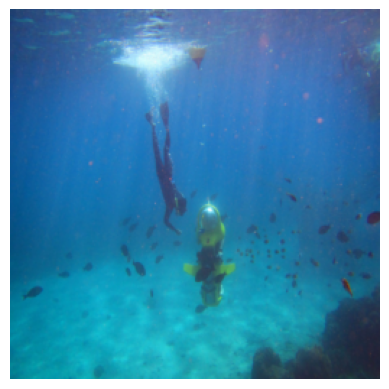

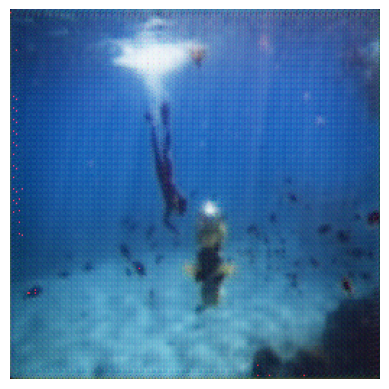

In [14]:
raw_img = transform_to_256("/kaggle/input/wec-underwater/Test/Raw/104_img_.png")
raw_img = raw_img.unsqueeze(0)

gen.eval()

with torch.no_grad():
    enhanced_img = gen(raw_img) 
    enhanced_img = enhanced_img.squeeze(0)
    enhanced_img = transforms.ToPILImage()(enhanced_img)

    plt.imshow(enhanced_img)
    plt.axis('off')  
    plt.show() 